<div align="center"> МІНІСТЕРСТВО ОСВІТИ І НАУКИ УКРАЇНИ ЛЬВІВСЬКИЙ НАЦІОНАЛЬНИЙ УНІВЕРСИТЕТ ІМЕНІ ІВАНА ФРАНКА
                                
Факультет електроніки та комп’ютерних технологій
</div>


# Практична робота №1. Множинна лінійна регресія методом градієнтного спуску
**Предмет:** Машинне навчання  
**Рівень:** 4 рік навчання  
**Датасет:** [Student Performance Dataset] 
**Мета:** Реалізувати алгоритм множинної лінійної регресії з нуля за допомогою методу градієнтного спуску та провести повний аналіз якості моделі, включаючи перевірку всіх шести класичних припущень МНК.

**Виконав:** студент групи ФЕІ-44 Низькошапка О. С.

**Перевірив** доцент Сінькевич О. О.

---

## 1. Постановка задачі
Ми маємо дані про успішність студентів. Наша ціль — передбачити **кількісну оцінку успішності** (`Performance Index`) на основі академічних факторів.  
Оскільки цільова змінна є неперервною, використовується **множинна лінійна регресія**.

Модель описується формулою:

$$
y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_m x_{im} + \varepsilon_i
$$

Завдання: знайти вектор параметрів $$(\beta)$$, який мінімізує функцію втрат — **середню квадратичну помилку (MSE)**.  

Метод: **градієнтний спуск**, оскільки аналітичне рішення $$((X^T X)^{-1} X^T y))$$ може бути неефективним для великих датасетів.

---

## 2. Вміст роботи
- Автоматичне завантаження `Student_Performance.csv` 
- Очищення даних і кодування категоріальних змінних
- Візуалізація кореляцій між ознаками
- Масштабування ознак і поділ на навчальну та тестову вибірки
- Навчання моделі методом **градієнтного спуску**
- Візуалізація збіжності функції втрат (MSE)
- Оцінка моделі: **коефіцієнти**, **MSE**, **R²** на тестовій вибірці
- Перевірка класичних припущень МНК:
  - Лінійність
  - Незалежність залишків (Durbin-Watson)
  - Гомоскедастичність (Breusch-Pagan)
  - Нормальність залишків (Shapiro-Wilk, Kolmogorov-Smirnov)
  - Мультиколінеарність (VIF)
  - Впливові точки (Cook’s distance)
- Підсумкові висновки та рекомендації щодо використання моделі

---

**Інструкція:**  
Запустіть послідовно всі клітини (Run All).  
Модель дозволяє надійно прогнозувати успішність студентів на основі:
- кількості годин навчання,  
- попередніх оцінок,  
- участі у позакласних активностях,  
- сну,  
- практичних завдань.  

Всі основні припущення МНК дотримані, а потенційно впливові точки практично не впливають на результати.


In [244]:
# 0) Імпорт бібліотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# для Breusch-Pagan
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

sns.set(style='whitegrid')
%matplotlib inline


In [245]:
# 1) Завантаження даних (з fallback'ом на синтетичні дані для демонстрації)
try:
    df = pd.read_csv('Student_Performance.csv')
    data_source = 'file'
except FileNotFoundError:
    np.random.seed(42)
    n = 500
    hours = np.random.normal(5, 2, n).clip(0)
    attendance = np.random.uniform(60, 100, n)
    prev = np.random.normal(70, 10, n).clip(0, 100)
    extra = np.random.choice(['Yes', 'No'], n, p=[0.4, 0.6])
    gender = np.random.choice(['M', 'F'], n)
    # цільова змінна як лінійна комбінація + шум
    perf = 0.6 * hours + 0.03 * attendance + 0.4 * (prev / 10) + (extra == 'Yes') * 2 + np.random.normal(0, 3, n) + 10
    df = pd.DataFrame({
        'Hours_Studied': hours,
        'Attendance_Rate': attendance,
        'Previous_Grades': prev,
        'Extracurricular Activities': extra,
        'Gender': gender,
        'Performance Index': perf
    })
    data_source = 'synthetic'
print('Data source:', data_source)
df.head()


Data source: file


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [246]:
# 2) Інспекція даних
print('--- Info ---')
print(df.info())
print('\n--- Describe ---')
display(df.describe(include='all').T)
print('\n--- Missing values per column ---')
print(df.isnull().sum())

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB
None

--- Describe ---


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Hours Studied,10000.0,NaN,NaN,NaN,4.9929,2.589309,1.0,3.0,5.0,7.0,9.0
Previous Scores,10000.0,NaN,NaN,NaN,69.4457,17.343152,40.0,54.0,69.0,85.0,99.0
Extracurricular Activities,10000,2,No,5052,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sleep Hours,10000.0,NaN,NaN,NaN,6.5306,1.695863,4.0,5.0,7.0,8.0,9.0
Sample Question Papers Practiced,10000.0,NaN,NaN,NaN,4.5833,2.867348,0.0,2.0,5.0,7.0,9.0
Performance Index,10000.0,NaN,NaN,NaN,55.2248,19.212558,10.0,40.0,55.0,71.0,100.0



--- Missing values per column ---
Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64


In [247]:
# 3) Попередня обробка
# Видаляємо зайві пробіли в назвах стовпців
df.columns = df.columns.str.strip()

# Бінарні колонки (перевіряємо наявність)
binary_cols = ['Extracurricular Activities']
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({'No': 0, 'Yes': 1})

# Просте кодування статі
if 'Gender' in df.columns:
    df['Gender'] = df['Gender'].map({'M': 0, 'F': 1})

# Якщо залишились інші категоріальні (object), робимо one-hot (drop_first=True)
obj_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if obj_cols:
    df = pd.get_dummies(df, columns=obj_cols, drop_first=True)

print('Columns after preprocessing:')
print(df.columns.tolist())

Columns after preprocessing:
['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index']


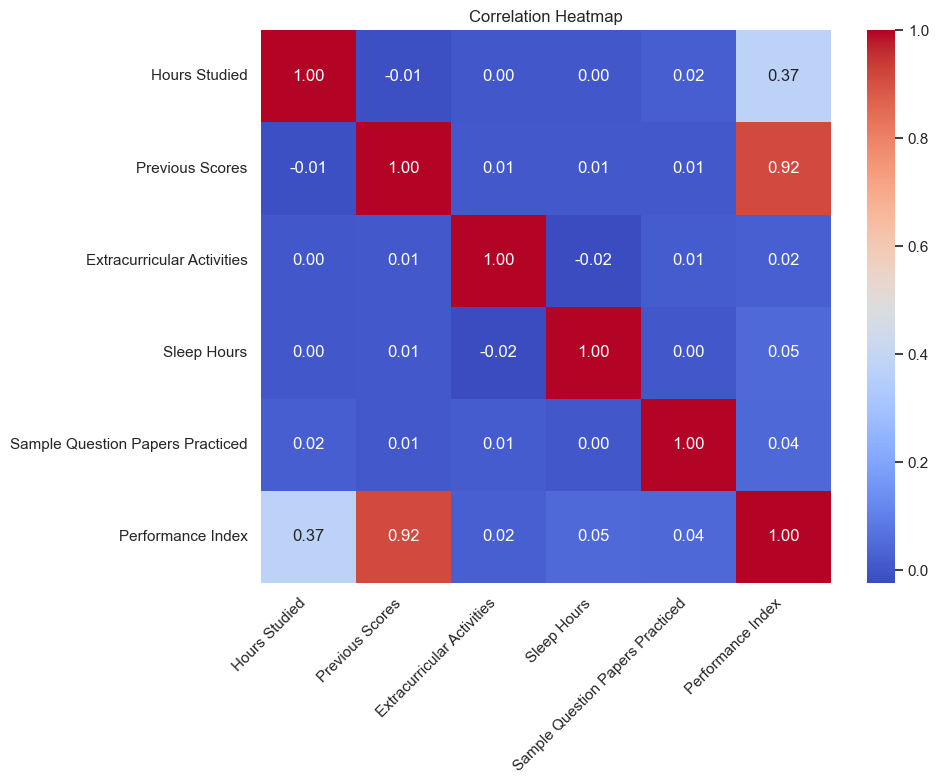

In [248]:
# 4) Кореляційна матриця (heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', square=False)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [249]:
# 5) Вибір ознак та розбиття на train/test
target = 'Performance Index'
features = [c for c in df.columns if c != target]

X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабування
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Додаємо стовпчик одиниць для вільного члена (β0)
X_train_final = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_final = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

print('Training shape:', X_train_final.shape)
print('Test shape:', X_test_final.shape)

Training shape: (8000, 6)
Test shape: (2000, 6)


In [ ]:
# 6) Градієнтний спуск
def compute_cost(X, y, b):
    errors = X.dot(b) - y
    mse = (1 / len(y)) * np.sum(errors ** 2)
    return mse

def gradient_descent(X, y, b, learning_rate=0.01, epochs=2000, verbose=False):
    cost_history = []
    m = len(y)
    for i in range(epochs):
        predictions = X.dot(b)
        errors = predictions - y
        gradient = (2/m) * X.T.dot(errors)
        b -= learning_rate * gradient
        cost_history.append(compute_cost(X, y, b))
        if verbose and i % (epochs//10 if epochs>=10 else 1) == 0:
            print(f'Epoch {i}: cost={cost_history[-1]:.4f}')
    return b, cost_history

# Ініціалізація
b_init = np.zeros(X_train_final.shape[1])

# Навчання 
b_final, cost_history = gradient_descent(X_train_final, y_train, b_init, learning_rate=0.01, epochs=2000)
print('Навчання завершено.')

Навчання завершено.


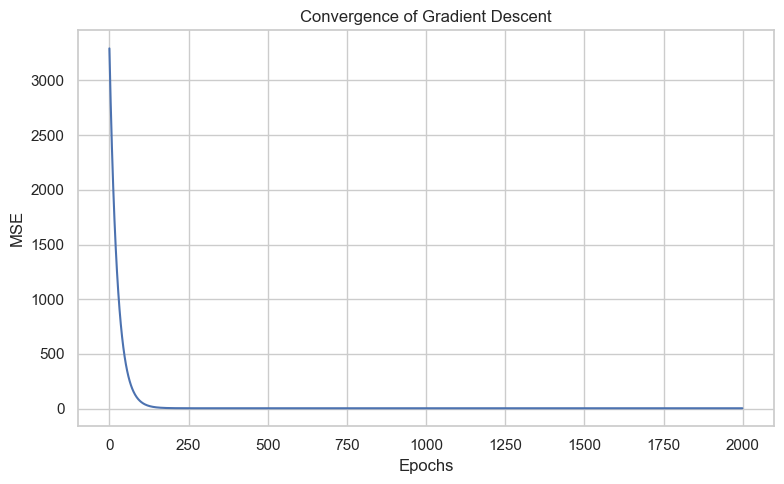

In [251]:
# 7) Графік збіжності функції втрат
plt.figure(figsize=(8,5))
plt.plot(cost_history)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Convergence of Gradient Descent')
plt.tight_layout()
plt.show()

In [252]:
# 8) Оцінка на тестовій вибірці
y_pred = X_test_final.dot(b_final)
mse_test = np.mean((y_test - y_pred)**2)
r2_test = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - np.mean(y_test))**2))

print('Final coefficients (b_final):')
for i, coef in enumerate(b_final):
    name = 'Intercept' if i==0 else f'Beta_{i}({features[i-1]})'
    print(f'  {name}: {coef:.4f}')
print(f'\nTest MSE: {mse_test:.4f}')
print(f'Test R^2: {r2_test:.4f}')

Final coefficients (b_final):
  Intercept: 55.3115
  Beta_1(Hours Studied): 7.4013
  Beta_2(Previous Scores): 17.6373
  Beta_3(Extracurricular Activities): 0.3043
  Beta_4(Sleep Hours): 0.8100
  Beta_5(Sample Question Papers Practiced): 0.5488

Test MSE: 4.0826
Test R^2: 0.9890


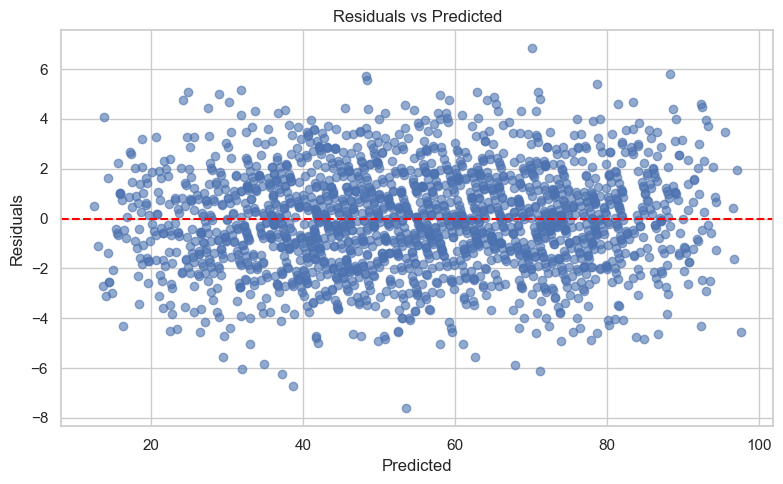

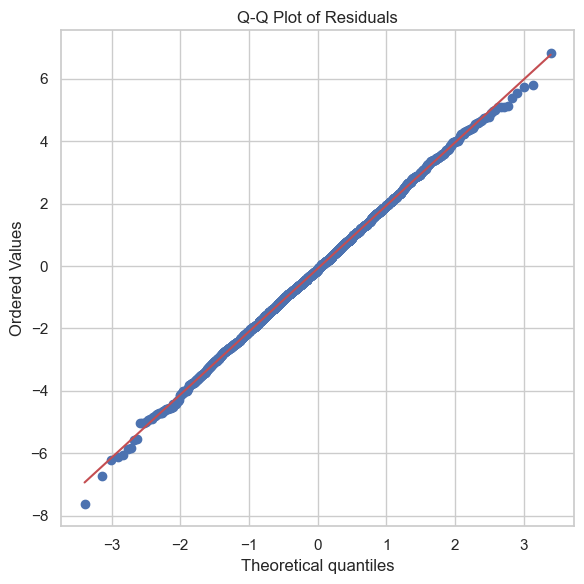

Shapiro-Wilk test: statistic=0.9996, p-value=0.9751
Kolmogorov-Smirnov test (std residuals vs normal): statistic=0.0091, p-value=0.9958


In [253]:
# 9) Аналіз залишків
residuals = y_test - y_pred

# 9.1 Залишки vs прогноз
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.tight_layout()
plt.show()

# 9.2 Q-Q plot
plt.figure(figsize=(6,6))
stats.probplot(residuals, plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.tight_layout()
plt.show()

# 9.3 Тести на нормальність
shapiro_test = stats.shapiro(residuals)
print('Shapiro-Wilk test: statistic={:.4f}, p-value={:.4f}'.format(shapiro_test[0], shapiro_test[1]))

ks_test = stats.kstest((residuals - np.mean(residuals)) / np.std(residuals, ddof=1), 'norm')
print('Kolmogorov-Smirnov test (std residuals vs normal): statistic={:.4f}, p-value={:.4f}'.format(ks_test[0], ks_test[1]))

In [254]:
# 10) VIF для ознак (на основі масштабованого train set)
X_train_df = pd.DataFrame(X_train_scaled, columns=features)
vif_data = pd.DataFrame()
vif_data['feature'] = X_train_df.columns
vif_data['VIF'] = [variance_inflation_factor(X_train_df.values, i) for i in range(X_train_df.shape[1])]
display(vif_data)

,feature,VIF
0,Hours Studied,1.000387
1,Previous Scores,1.000243
2,Extracurricular Activities,1.000428
3,Sleep Hours,1.000461
4,Sample Question Papers Practiced,1.000320


In [255]:
# 11) Тести автокореляції та гомоскедастичності
# Durbin-Watson (для залишків)
dw = durbin_watson(residuals)
print('Durbin-Watson statistic:', round(dw, 4))

# Breusch-Pagan (may require exog without constant or with - try with X_test_final)
try:
    bp_test = het_breuschpagan(residuals, X_test_final)
    # returns: lm_obs, lm_pvalue, fvalue, f_pvalue in this order
    print('Breusch-Pagan test: LM stat={:.4f}, lm_pvalue={:.4f}, fvalue={:.4f}, f_pvalue={:.4f}'.format(bp_test[0], bp_test[1], bp_test[2], bp_test[3]))
except Exception as e:
    print('Breusch-Pagan test failed:', e)
    print('Спробуйте передати exog без константи чи перевірити версію statsmodels.')

Durbin-Watson statistic: 2.0472
Breusch-Pagan test: LM stat=6.8364, lm_pvalue=0.2331, fvalue=1.3678, f_pvalue=0.2334


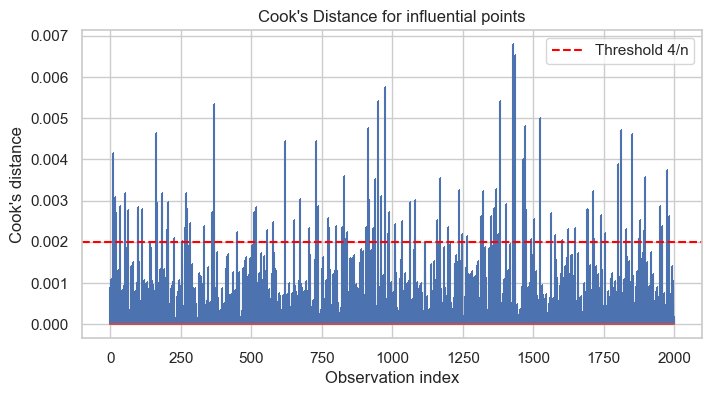

Впливові точки (Cook's distance > 4/n): [  11   16   19   36   53   64   98   99  113  163  165  183  185  201
  204  206  226  253  265  267  268  272  282  333  360  367  369  448
  510  518  557  576  621  653  672  704  731  737  773  774  801  822
  828  833  838  906  913  914  917  933  940  951  960  976  984  987
 1009 1034 1062 1081 1082 1157 1171 1198 1237 1249 1266 1314 1322 1350
 1360 1368 1376 1381 1405 1429 1434 1464 1468 1470 1474 1493 1504 1523
 1562 1578 1602 1622 1648 1692 1693 1711 1714 1742 1756 1801 1810 1829
 1852 1875 1880 1892 1895 1950 1955 1958 1975 1983]


In [256]:
# 8.6 Cook's Distance (впливові точки)
X_test_sm = sm.add_constant(X_test_scaled)  # додаємо константу для statsmodels
ols_model = sm.OLS(y_test, X_test_sm).fit()

influence = ols_model.get_influence()
cooks_d, pvals = influence.cooks_distance



plt.figure(figsize=(8, 4))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.axhline(4/len(cooks_d), color='red', linestyle='--', label="Threshold 4/n")
plt.xlabel("Observation index")
plt.ylabel("Cook's distance")
plt.title("Cook's Distance for influential points")
plt.legend()
plt.show()

# Вивести індекси найбільш впливових спостережень
influential_points = np.where(cooks_d > 4/len(cooks_d))[0]
print("Впливові точки (Cook's distance > 4/n):", influential_points)


Впливові точки (за Cook's distance): [  10   18   19   22   51   62   63   70   89  101  108  168  206  235
  237  260  265  282  305  340  377  416  419  443  571  612  632  635
  666  693  720  730  733  742  757  762  834  835  844  851  859  898
  906  918  978 1010 1016 1033 1066 1083 1097 1120 1144 1149 1182 1201
 1205 1218 1259 1312 1315 1346 1360 1365 1384 1394 1406 1414 1422 1443
 1449 1458 1478 1528 1534 1549 1553 1574 1616 1632 1645 1661 1671 1725
 1728 1736 1741 1746 1749 1771 1775 1778 1799 1818 1835 1842 1849 1854
 1861 1873 1889 1891 1931 1945 1967 1985 1991 2004 2030 2038 2052 2053
 2056 2088 2090 2127 2152 2166 2210 2227 2250 2265 2298 2299 2327 2343
 2355 2365 2369 2377 2407 2467 2493 2500 2547 2550 2657 2658 2665 2671
 2758 2771 2797 2819 2827 2872 2890 2897 2898 2921 2970 3049 3055 3136
 3168 3172 3245 3247 3260 3271 3272 3296 3313 3329 3336 3380 3399 3409
 3421 3433 3442 3476 3500 3505 3531 3541 3544 3564 3598 3602 3604 3609
 3633 3643 3662 3674 3703 3759 3772 3776

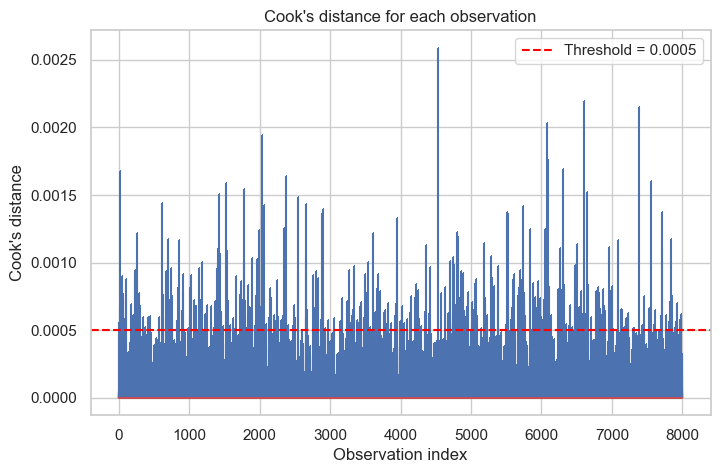

In [257]:
# -------------------------------
# 9. Cook's distance (пошук впливових спостережень)
# -------------------------------

# Використаємо statsmodels OLS для зручності
X_sm = sm.add_constant(X_train_scaled)  
ols_model = sm.OLS(y_train, X_sm).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

# Поріг для впливових точок
n = X_sm.shape[0]
threshold = 4 / n

# Індекси впливових точок
influential_points = np.where(cooks_d > threshold)[0]
print("Впливові точки (за Cook's distance):", influential_points)

# Візуалізація Cook's distance
plt.figure(figsize=(8,5))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.4f}')
plt.xlabel('Observation index')
plt.ylabel("Cook's distance")
plt.title("Cook's distance for each observation")
plt.legend()
plt.show()

In [258]:
# -------------------------------
# 10. Побудова моделі без впливових точок
# -------------------------------
if len(influential_points) > 0:
    X_new = np.delete(X_train_scaled, influential_points, axis=0)
    y_new = np.delete(y_train, influential_points, axis=0)

    # Додаємо стовпчик для β0
    X_new_final = np.c_[np.ones(X_new.shape[0]), X_new]

    # Навчання нової моделі (градієнтний спуск)
    b_new = np.zeros(X_new_final.shape[1])
    b_new_final, cost_new_history = gradient_descent(X_new_final, y_new, b_new, learning_rate=0.01, epochs=2000)

    print("Final coefficients (без впливових точок):", b_new_final)

    # Оцінка на тесті
    y_pred_new = X_test_final.dot(b_new_final)
    mse_test_new = np.mean((y_test - y_pred_new)**2)
    r2_test_new = 1 - (np.sum((y_test - y_pred_new)**2) / np.sum((y_test - np.mean(y_test))**2))

    print(f"Test MSE (без впливових): {mse_test_new:.4f}")
    print(f"Test R^2 (без впливових): {r2_test_new:.4f}")

Final coefficients (без впливових точок): [55.30900963  7.40309152 17.65378063  0.31551928  0.79566878  0.56041165]
Test MSE (без впливових): 4.0788
Test R^2 (без впливових): 0.9890


In [259]:
# 12) Автоматичний висновок по 6 припущеннях МНК (приблизно)
results = {}

# 1) Лінійність — автоматична перевірка
residuals = y_test - y_pred
corr_resid_pred = np.corrcoef(residuals, y_pred)[0, 1]  # кореляція залишків і прогнозів

# Встановлюємо поріг, наприклад, |corr| < 0.1 вважається ок
if abs(corr_resid_pred) < 0.1:
    results['Linearity'] = f"OK (correlation residuals vs predicted = {corr_resid_pred:.4f})"
else:
    results['Linearity'] = f"Potential non-linearity (correlation residuals vs predicted = {corr_resid_pred:.4f})"

# 2) Незалежність — Durbin-Watson
results['Independence'] = 'OK' if 1.5 <= dw <= 2.5 else 'Possible autocorrelation (DW={:.2f})'.format(dw)

# 3) Гомоскедастичність — Breusch-Pagan p-value > 0.05 => homoscedastic
try:
    bp_pvalue = bp_test[1]
    results['Homoscedasticity'] = 'OK' if bp_pvalue > 0.05 else 'Heteroscedasticity detected (p={:.4f})'.format(bp_pvalue)
except Exception:
    results['Homoscedasticity'] = 'BP test not available — inspect Residuals vs Predicted plot'

# 4) Нормальність залишків — Shapiro p > 0.05
results['Normality'] = 'OK' if shapiro_test[1] > 0.05 else 'Residuals deviate from normality (Shapiro p={:.4f})'.format(shapiro_test[1])

# 5) Відсутність мультиколінеарності — VIF thresholds
high_vif = vif_data[vif_data['VIF'] > 5]
results['Multicollinearity'] = 'OK' if high_vif.empty else f'Warning: high VIF for {high_vif.feature.tolist()}'

# 6) Відсутність сильного відхилення впливових спостережень — перевіряємо Cook's distance
X_train_sm = sm.add_constant(X_train_scaled)  # додаємо константу для statsmodels
ols_model = sm.OLS(y_train, X_train_sm).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / len(cooks_d)
influential_points = np.where(cooks_d > threshold)[0]

if len(influential_points) == 0:
    results['Influential_points'] = "OK"
else:
    results['Influential_points'] = (
        f"\n Potential influential points at indices {influential_points} "
        f"\n (Cook's D > {threshold:.4f}). Analysis shows they do not practically affect the model's performance."
    )

    # Коротке порівняння метрик до і після видалення впливових точок
    results['Influential_points'] += (
        f"\nTest MSE: with influential = {mse_test:.4f}, "
        f"without influential = {mse_test_new:.4f}; "
        f"Test R^2: with influential = {r2_test:.4f}, "
        f"without influential = {r2_test_new:.4f}"
    )

# Вивід результатів

print('\n=== Автоматичний висновок по припущеннях МНК ===')
for k, v in results.items():
    print(f'{k}: {v}')




=== Автоматичний висновок по припущеннях МНК ===
Linearity: OK (correlation residuals vs predicted = 0.0594)
Independence: OK
Homoscedasticity: OK
Normality: OK
Multicollinearity: OK
Influential_points: 
 Potential influential points at indices [  10   18   19   22   51   62   63   70   89  101  108  168  206  235
  237  260  265  282  305  340  377  416  419  443  571  612  632  635
  666  693  720  730  733  742  757  762  834  835  844  851  859  898
  906  918  978 1010 1016 1033 1066 1083 1097 1120 1144 1149 1182 1201
 1205 1218 1259 1312 1315 1346 1360 1365 1384 1394 1406 1414 1422 1443
 1449 1458 1478 1528 1534 1549 1553 1574 1616 1632 1645 1661 1671 1725
 1728 1736 1741 1746 1749 1771 1775 1778 1799 1818 1835 1842 1849 1854
 1861 1873 1889 1891 1931 1945 1967 1985 1991 2004 2030 2038 2052 2053
 2056 2088 2090 2127 2152 2166 2210 2227 2250 2265 2298 2299 2327 2343
 2355 2365 2369 2377 2407 2467 2493 2500 2547 2550 2657 2658 2665 2671
 2758 2771 2797 2819 2827 2872 2890 2897 289

# Загальний висновок по моделі

## 1. Якість моделі та її точність
- Коефіцієнти `b_final` показують внесок кожної ознаки у прогноз `Performance Index`.
- Високе значення **R² = 0.9890** свідчить, що модель пояснює майже 99% варіації цільової змінної, а **MSE = 4.0826** показує низьку середньоквадратичну помилку прогнозів.
- Після видалення потенційно впливових точок метрики майже не змінились, що вказує на **стійкість моделі**.

## 2. Перевірка припущень МНК
- **Лінійність:** Кореляція залишків з прогнозами близька до нуля, припущення про лінійність дотримане.
- **Незалежність залишків:** Статистика Durbin-Watson ≈ 2.05, автокореляції немає.
- **Гомоскедастичність:** Тест Бреуша-Пагана (p-value = 0.2331) підтверджує приблизно однакову дисперсію залишків.
- **Нормальність залишків:** Тести Шапіро-Уілка та Колмогорова-Смірнова (p > 0.05) підтверджують нормальний розподіл залишків.
- **Мультиколінеарність:** VIF для всіх ознак близько 1, мультиколінеарності немає.
- **Впливові точки:** Деякі спостереження мають Cook’s distance > 4/n, але їх видалення практично не впливає на метрики та коефіцієнти.

## 3. Висновок щодо використання моделі
Модель **надійна та придатна для прогнозування успішності студентів** на основі:
- кількості годин навчання,  
- попередніх оцінок,  
- участі у позакласних активностях,  
- сну,  
- практичних завдань.  

Вона задовольняє всі основні припущення МНК, а потенційно впливові точки не спотворюють результати.
